In [75]:
import torch

In [76]:
torch.__version__

'1.8.1+cpu'

In [77]:
from skimage import io
import numpy as np

# 读取原图

In [115]:
# img1 = io.imread('C:/Users/lyw10/Desktop/learning/大二下/小学期实验/数据/模拟数据/原图/peppers256.png')
img1 = io.imread('C:/Users/lyw10/Desktop/learning/大二下/小学期实验/数据/模拟数据/原图/original.png')

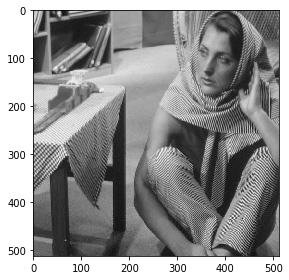

In [116]:
io.imshow(img1)

In [117]:
def normalize(img):
    mean=255/2
    std=255/2
    return (img - mean) / std

def inNormalize(img):
    mean=255/2
    std=255/2
    return img*std+mean

In [118]:
img1.shape

(512, 512)

In [119]:
#归一化后转成float，和原文中一样
img1_nor = normalize(img1)
img1_nor.shape

(512, 512)

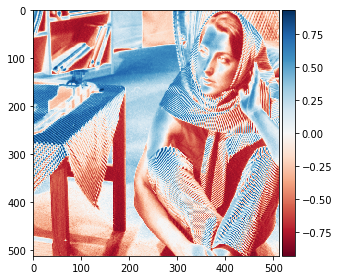

In [120]:
io.imshow(img1_nor)

In [84]:
img1_nor  #已经归一化和转换为float类型

array([[-0.19215686, -0.2       , -0.2       , ..., -0.19215686,
        -0.2       , -0.27843137],
       [-0.20784314, -0.2       , -0.20784314, ..., -0.2627451 ,
        -0.24705882, -0.24705882],
       [-0.2       , -0.20784314, -0.17647059, ..., -0.31764706,
        -0.24705882, -0.23137255],
       ...,
       [ 0.39607843,  0.35686275,  0.35686275, ...,  0.08235294,
         0.12156863,  0.08235294],
       [ 0.37254902,  0.34901961,  0.35686275, ...,  0.08235294,
         0.11372549,  0.05882353],
       [ 0.35686275,  0.35686275,  0.34901961, ...,  0.11372549,
         0.08235294,  0.06666667]])

# 读取噪声图

In [161]:
img1_noise1 = io.imread('C:/Users/lyw10/Desktop/learning/大二下/小学期实验/数据/模拟数据/噪声图/noisy-24.6008-0.83881.png')
#img1_noise2 = io.imread('C:/Users/lyw10/Desktop/learning/大二下/小学期实验/数据/模拟数据/噪声图/lena_Sigma3.png')

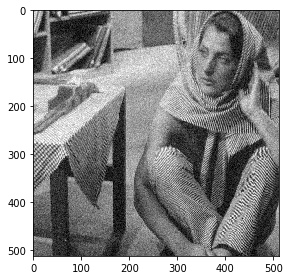

In [162]:
io.imshow(img1_noise1)

In [163]:
img1_noise1_nor = normalize(img1_noise1)
#img1_noise2_nor = normalize(img1_noise2)

In [164]:
img1_noise1_nor.shape

(512, 512)

# 使用模型降噪

In [165]:
import Deep_KSVD
from scipy import linalg
patch_size = 8
m = 16
device = torch.device("cpu")

Dict_init = Deep_KSVD.init_dct(patch_size, m)
Dict_init = Dict_init.to(device)

# Squared Spectral norm:
c_init = linalg.norm(Dict_init, ord=2) ** 2
c_init = torch.FloatTensor((c_init,))
c_init = c_init.to(device)

# Average weight:
w_init = torch.normal(mean=1, std=1 / 10 * torch.ones(patch_size ** 2)).float()
w_init = w_init.to(device)

# Deep-KSVD:
D_in, H_1, H_2, H_3, D_out_lam, T, min_v, max_v = patch_size ** 2, 128, 64, 32, 1, 7, -1, 1
model = Deep_KSVD.DenoisingNet_MLP(
    patch_size,
    D_in,
    H_1,
    H_2,
    H_3,
    D_out_lam,
    T,
    min_v,
    max_v,
    Dict_init,
    c_init,
    w_init,
    device,
)


In [166]:

device = torch.device("cpu")
model.load_state_dict(torch.load("C:/Users/lyw10/Desktop/learning/大二下/小学期实验/实验结果/DKSVD5/model.pth", map_location="cpu"))
model.to(device)

DenoisingNet_MLP(
  (unfold): Unfold(kernel_size=(8, 8), dilation=1, padding=0, stride=1)
  (linear1): Linear(in_features=64, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=1, bias=True)
)

In [167]:
#注意：这里只用在超声图像中
#img1_noise1_nor = img1_nor

In [168]:
img1_noise1_nor == img1_nor

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False]])

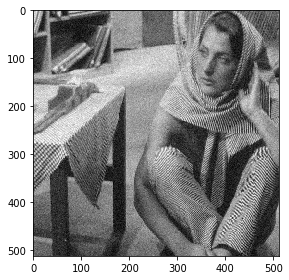

In [169]:
w,h=img1_noise1_nor.shape
with torch.no_grad():
    img2 = img1_noise1_nor.reshape(1,1,w,h)
    img2 = np.float32(img2)
    img_denoise1 = model(torch.from_numpy(img2))
    image_dnoise1 = img_denoise1[0, 0, :, :]
    real_denoise = inNormalize(image_dnoise1).numpy().astype('uint8')
    io.imshow(real_denoise)
    io.imsave('C:/Users/lyw10/Desktop/learning/大二下/小学期实验/数据/模拟数据/降噪图_sigma=5/noisy-24.6008-0.83881_denoise1.png',real_denoise)

# 计算原图与噪声图的PSNR和SSIM

In [170]:
# #用原文方法计算PSNR
# PSNR_init = 10 * torch.log10(4 / torch.mean((torch.from_numpy(img1_nor) - torch.from_numpy(img1_noise1_nor)) ** 2))
# PSNR_init
# #PSNR_de = 10 * torch.log10(4 / torch.mean((image_true_t - image_noise_0) ** 2))

In [171]:
# import math
# #老师提供的公式，log底数是10（不知道写的对不对）
# PSNR_init_1 = 20 * np.log10(255 / math.sqrt(torch.mean((torch.from_numpy(img1_nor) - torch.from_numpy(img1_noise1_nor)) ** 2)))
# PSNR_init_1

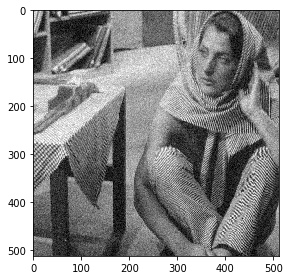

In [172]:
io.imshow(img1_noise1)

In [173]:
#计算原图和噪声图的PSNR
import math
PSNR_init_1 = 20 * np.log10(255 / math.sqrt(np.mean((img1.astype(float) - img1_noise1.astype(float)) ** 2)))
PSNR_init_1

24.62010804202647

In [174]:
#计算降噪图与原图的PSNR
PSNR_init_2 = 20 * np.log10(255 / math.sqrt(np.mean((img1.astype(float) - real_denoise.astype(float)) ** 2)))
PSNR_init_2

26.542285775646363

In [175]:
# #用库的方法计算PSNR，原图和噪声图
# import skimage
# from skimage.metrics import mean_squared_error
# from skimage.metrics import peak_signal_noise_ratio

# MSE = mean_squared_error(img1_nor, img1_noise1_nor)
# PSNR = peak_signal_noise_ratio(img1_nor, img1_noise1_nor)

# print('MSE: ', MSE)
# print('PSNR: ', PSNR)  

In [176]:
#用库的方法计算SSIM
import skimage
from skimage.measure import compare_ssim
ssim1 = skimage.measure.compare_ssim(img1_nor, img1_noise1_nor, data_range=255)
ssim2 = skimage.measure.compare_ssim(img1, img1_noise1, data_range=255)
print('SSIM1: ', ssim1)
print('SSIM2: ', ssim2)
#为啥正则化之后相似度这么高

SSIM1:  0.9997223771880221
SSIM2:  0.6022973584021077


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


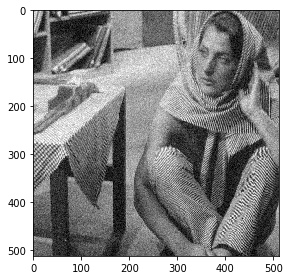

In [177]:
io.imshow(img1_noise1)

# 计算降噪图与原图的PSNR和SSIM

In [178]:
# #用库的方法计算PSNR，原图和噪声图
# import skimage
# from skimage.metrics import mean_squared_error
# from skimage.metrics import peak_signal_noise_ratio

# MSE = mean_squared_error(img1_nor, normalize(real_denoise))
# PSNR = peak_signal_noise_ratio(img1_nor, normalize(real_denoise))

# print('MSE: ', MSE)
# print('PSNR: ', PSNR)  

In [179]:
#用库的方法计算SSIM
from skimage.measure import compare_ssim
#归一化后对比
ssim1 = skimage.measure.compare_ssim(img1_nor, normalize(real_denoise), data_range=255)
#原图对比
ssim2 = skimage.measure.compare_ssim(img1,real_denoise, data_range=255)
print('SSIM1: ', ssim1)
print('SSIM2: ', ssim2)


SSIM1:  0.9998095006737495
SSIM2:  0.6752201773155119


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


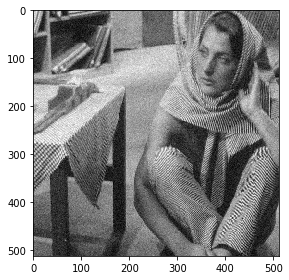

In [180]:
io.imshow(real_denoise)